# Car Prediction

Using k-nearest neighbors, we're trying to predict the pricing of the car based on well-known features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold


%matplotlib inline

#print(cars.columns)
#cars.dtypes
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv("imports-85.data",names=cols)
cars.head()

symboling normalized-losses         make fuel-type aspiration num-of-doors  \
0          3                 ?  alfa-romero       gas        std          two   
1          3                 ?  alfa-romero       gas        std          two   
2          1                 ?  alfa-romero       gas        std          two   
3          2               164         audi       gas        std         four   
4          2               164         audi       gas        std         four   

    body-style drive-wheels engine-location  wheel-base  ...    engine-size  \
0  convertible          rwd           front        88.6  ...            130   
1  convertible          rwd           front        88.6  ...            130   
2    hatchback          rwd           front        94.5  ...            152   
3        sedan          fwd           front        99.8  ...            109   
4        sedan          4wd           front        99.4  ...            136   

   fuel-system  bore  stroke compression-rate horsepower  peak-rpm city-mpg  \
0         mpfi  3.47    2.68              9.0        111      5000       21   
1         mpfi  3.47    2.68              9.0        111      5000       21   
2         mpfi  2.68    3.47              9.0        154      5000       19   
3         mpfi  3.19    3.40             10.0        102      5500       24   
4         mpfi  3.19    3.40              8.0        115      5500       18   

  highway-mpg  price  
0          27  13495  
1          27  16500  
2          26  16500  
3          30  13950  
4          22  17450  

[5 rows x 26 columns]

In [2]:
#replacing "?" data into numeric for training
#Changing datatypes for numeric values/continuous values
#https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names
#only selecting values for Linear Regression

cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
new_cars = cars[cols]
new_cars = new_cars.replace("?",np.nan)
new_cars.head()

normalized-losses  wheel-base  length  width  height  curb-weight  bore  \
0               NaN        88.6   168.8   64.1    48.8         2548  3.47   
1               NaN        88.6   168.8   64.1    48.8         2548  3.47   
2               NaN        94.5   171.2   65.5    52.4         2823  2.68   
3               164        99.8   176.6   66.2    54.3         2337  3.19   
4               164        99.4   176.6   66.4    54.3         2824  3.19   

  stroke  compression-rate horsepower peak-rpm  city-mpg  highway-mpg  price  
0   2.68               9.0        111     5000        21           27  13495  
1   2.68               9.0        111     5000        21           27  16500  
2   3.47               9.0        154     5000        19           26  16500  
3   3.40              10.0        102     5500        24           30  13950  
4   3.40               8.0        115     5500        18           22  17450

In [3]:
#we're replacing all the missing data with average values
new_cars = new_cars.astype(float) #we already filtered out numeric columns
avg_norm_losses = new_cars['normalized-losses'].mean()
#avg_norm_losses
new_cars['normalized-losses'].replace(np.nan, avg_norm_losses,inplace=True)
new_cars.head()
new_cars['normalized-losses'].isnull().sum()

0

In [4]:
new_cars_ref = new_cars.copy()
#follow the same logic for other columns
cols = new_cars.columns.tolist()
for col in cols:
    if new_cars[col].isnull().sum()  > 0:
        avg = new_cars[col].mean()
        new_cars[col].replace(np.nan,avg,inplace=True)
new_cars.isnull().sum() #woot!

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

In [5]:
#normalize all columns but the price column (min-max normalization)
cols = new_cars.columns.tolist()
cols.remove("price")
cols

for col in cols:
    max_ = new_cars[col].max()
    min_ = new_cars[col].min()
    mean_ = new_cars[col].mean()
    new_cars[col] = (new_cars[col] - mean_)/(max_ - min_)
new_cars.head()

normalized-losses  wheel-base    length     width    height  curb-weight  \
0           0.000000   -0.296110 -0.078347 -0.150650 -0.410407    -0.002935   
1           0.000000   -0.296110 -0.078347 -0.150650 -0.410407    -0.002935   
2           0.000000   -0.124099 -0.042526 -0.033984 -0.110407     0.103737   
3           0.219895    0.030420  0.038071  0.024350  0.047927    -0.084781   
4           0.219895    0.018758  0.038071  0.041016  0.047927     0.104125   

       bore    stroke  compression-rate  horsepower  peak-rpm  city-mpg  \
0  0.100178 -0.274011         -0.071409    0.028099 -0.051171 -0.117209   
1  0.100178 -0.274011         -0.071409    0.028099 -0.051171 -0.117209   
2 -0.464108  0.102180         -0.071409    0.207266 -0.051171 -0.172764   
3 -0.099822  0.068846         -0.008909   -0.009401  0.152910 -0.033875   
4 -0.099822  0.068846         -0.133909    0.044766  0.152910 -0.200542   

   highway-mpg    price  
0    -0.098716  13495.0  
1    -0.098716  16500.0  
2    -0.125032  16500.0  
3    -0.019769  13950.0  
4    -0.230295  17450.0

In [6]:
def knn_train_test(k_num,train_col,target_col,df):
    seed = np.random.seed(1)
    shuffle = np.random.permutation(df.index)
    df_new = df.reindex(shuffle)
    divider = int(len(df)*0.75)
    
    train_set = df.iloc[0:divider]
    test_set = df.iloc[divider:]
    
    knn = KNeighborsRegressor(n_neighbors=k_num,algorithm='auto')
    knn.fit(train_set[train_col],train_set[target_col])
    hypothesis = knn.predict(test_set[train_col])
    mse = mean_squared_error(test_set[target_col],hypothesis)
    return mse**0.5 #rmse

knn = knn_train_test(10,['horsepower','highway-mpg'],['price'],new_cars)
knn

2353.381880478646

Text(0.5,0,'k-value')

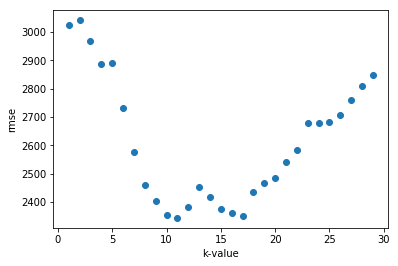

In [7]:
#testing out different k-values, plotting the loss function against k
rmse = list()
for i in range(1,30):
    result = knn_train_test(i,['horsepower','highway-mpg'],['price'],new_cars)
    rmse.append(result)
rmse
plt.scatter(range(1,30),rmse)
plt.ylabel("rmse")
plt.xlabel("k-value")
#seems like we have 2 good local min at 11 and 17

It seems that we have a double minimum valleys here. In theory, 11 and 17 would be ok. Before that, we have underfitting. After that, we have overfitting.

Text(0.5,0,'k-value')

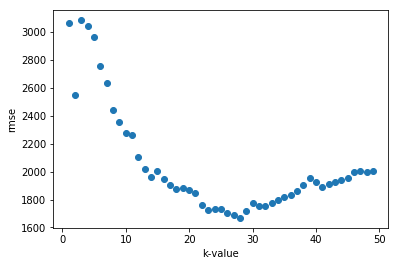

In [8]:
#more columns (all columns)
rmse = list()
for i in range(1,50):
    result = knn_train_test(i,cols,['price'],new_cars)
    rmse.append(result)
rmse
plt.scatter(range(1,50),rmse)
plt.ylabel("rmse")
plt.xlabel("k-value")
#we look to be able to reach a min value of ~$1600 error with all parameters
#Generally, more parameters = better but not neccessarily always. Obviously it's still better than previous model

In [9]:
#prevent too much overfitting
#modifying our train function to include cross validation
#n_split for cv validation, k_num for # of k-clusters, train_col = features, target_col = results column,
#df = dataframe
def knn_train_test2(n_split,k_num,train_col,target_col,df):
    seed = np.random.seed(1)
    kf = KFold(n_splits=n_split,shuffle=True,random_state=1)
    shuffle = np.random.permutation(df.index)
    df_new = df.reindex(shuffle)
    divider = int(len(df)*0.75)
    
    train_set = df.iloc[0:divider]
    test_set = df.iloc[divider:]
    
    knn = KNeighborsRegressor(n_neighbors=k_num,algorithm='auto')
    #knn.fit(train_set[train_col],train_set[target_col])
    mses = cross_val_score(knn,df[train_col],df[target_col],
	scoring="neg_mean_squared_error",cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    rmse = np.mean(rmses)
    #hypothesis = knn.predict(test_set[train_col])
    #mse = mean_squared_error(test_set[target_col],hypothesis)
    return  rmse

knn = knn_train_test2(4,10,['horsepower','highway-mpg'],['price'],new_cars)
knn


3811.0457726512686

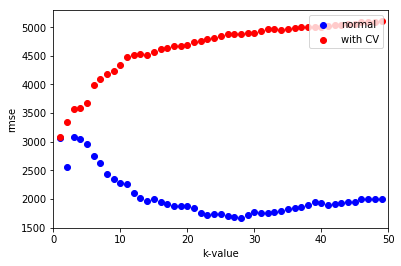

7868.7682123438


In [10]:
rmse = list() #normal
rmse_2 = list() #with cross validation
for i in range(1,50):
    result = knn_train_test(i,cols,['price'],new_cars)
    result2 = knn_train_test2(10,i,cols,['price'],new_cars)
    rmse.append(result)
    rmse_2.append(result2)
rmse
plt.close()
plt.scatter(range(1,50),rmse,c='b') 
plt.scatter(range(1,50),rmse_2,c='r')
plt.xlim(0,50)
plt.legend(["normal","with CV"],loc="upper right")
plt.ylabel("rmse")
plt.xlabel("k-value")
plt.show()
print(new_cars["price"].std())
#is the divergence real? Error is still within 1 std of the price column. There is no local minum seen in the CV function.


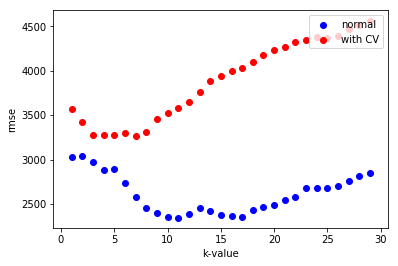

In [11]:
#we know that 2 parameters: ['horsepower','highway-mpg'] affects the price point, let's test out with the cv
cols = ['horsepower','highway-mpg']
rmse = list()
rmse_2 = list()
for i in range(1,30):
    result = knn_train_test(i,cols,['price'],new_cars)
    result2 = knn_train_test2(20,i,cols,['price'],new_cars)
    rmse.append(result)
    rmse_2.append(result2)
    
plt.scatter(range(1,30),rmse,c='b')
plt.scatter(range(1,30),rmse_2,c='r')
plt.legend(["normal","with CV"],loc="upper right")
plt.ylabel("rmse")
plt.xlabel("k-value")
plt.show()
#playing around with the cv splits does help a bit with the full divergence problem.


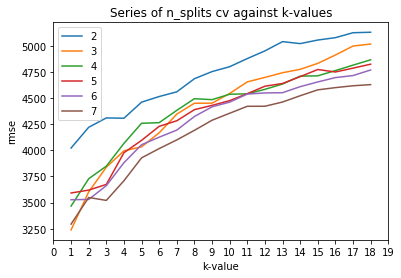

In [12]:
import seaborn as sns

#Let's plot out the number of cross validation splits vs. k-value
cols = new_cars.columns.tolist()
cols.remove('price')
def cv_matrix(n_split, k_num,cols,target,df):
    result = dict() #key= k_num, val=(n_split,error)
    for k in range(1,k_num):
        for n in range(2,n_split):
            rmse = knn_train_test2(n,k,cols,target,df)
            if n not in result:
                result[n] = [0]
            else:
                result[n].append(rmse)
    return result

knn_cv = cv_matrix(8,20,cols,['price'],new_cars)
knn_cv        

for key in knn_cv:
    rmse_results = knn_cv[key]
    #x is the size of the k values iterated above, y are the errors
    sns.lineplot(x=range(1,len(rmse_results)),y=rmse_results[1:],legend="full")
    plt.xticks([i for i in range(len(rmse_results)+1)])
plt.legend([i for i in range(2,11)])
plt.xlabel("k-value")
plt.ylabel("rmse")
plt.title("Series of n_splits cv against k-values")
plt.show()

Based on this, it seems that we are in the problem of feature engineering instead of matrix modeling building. Let's focus on picking some of the best parameters and assign the needed inputs from there. There's a major problem when there is no local minimum with the matrix.
Plan of attack: We need to find the features that are well-correlated to the price, and only use those to help predict our price. Secondly, we will use an ensemble technique of multiple machine learning algorithms to see which one has the best RMSE

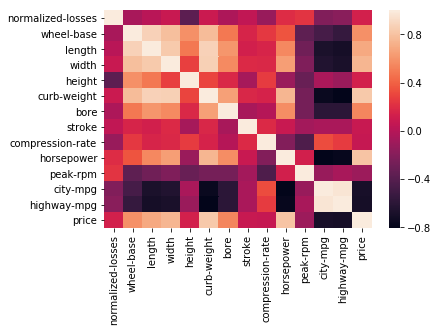

In [13]:
sns.heatmap(new_cars_ref.corr())

Let's visualize even further on how each parameter would be affected

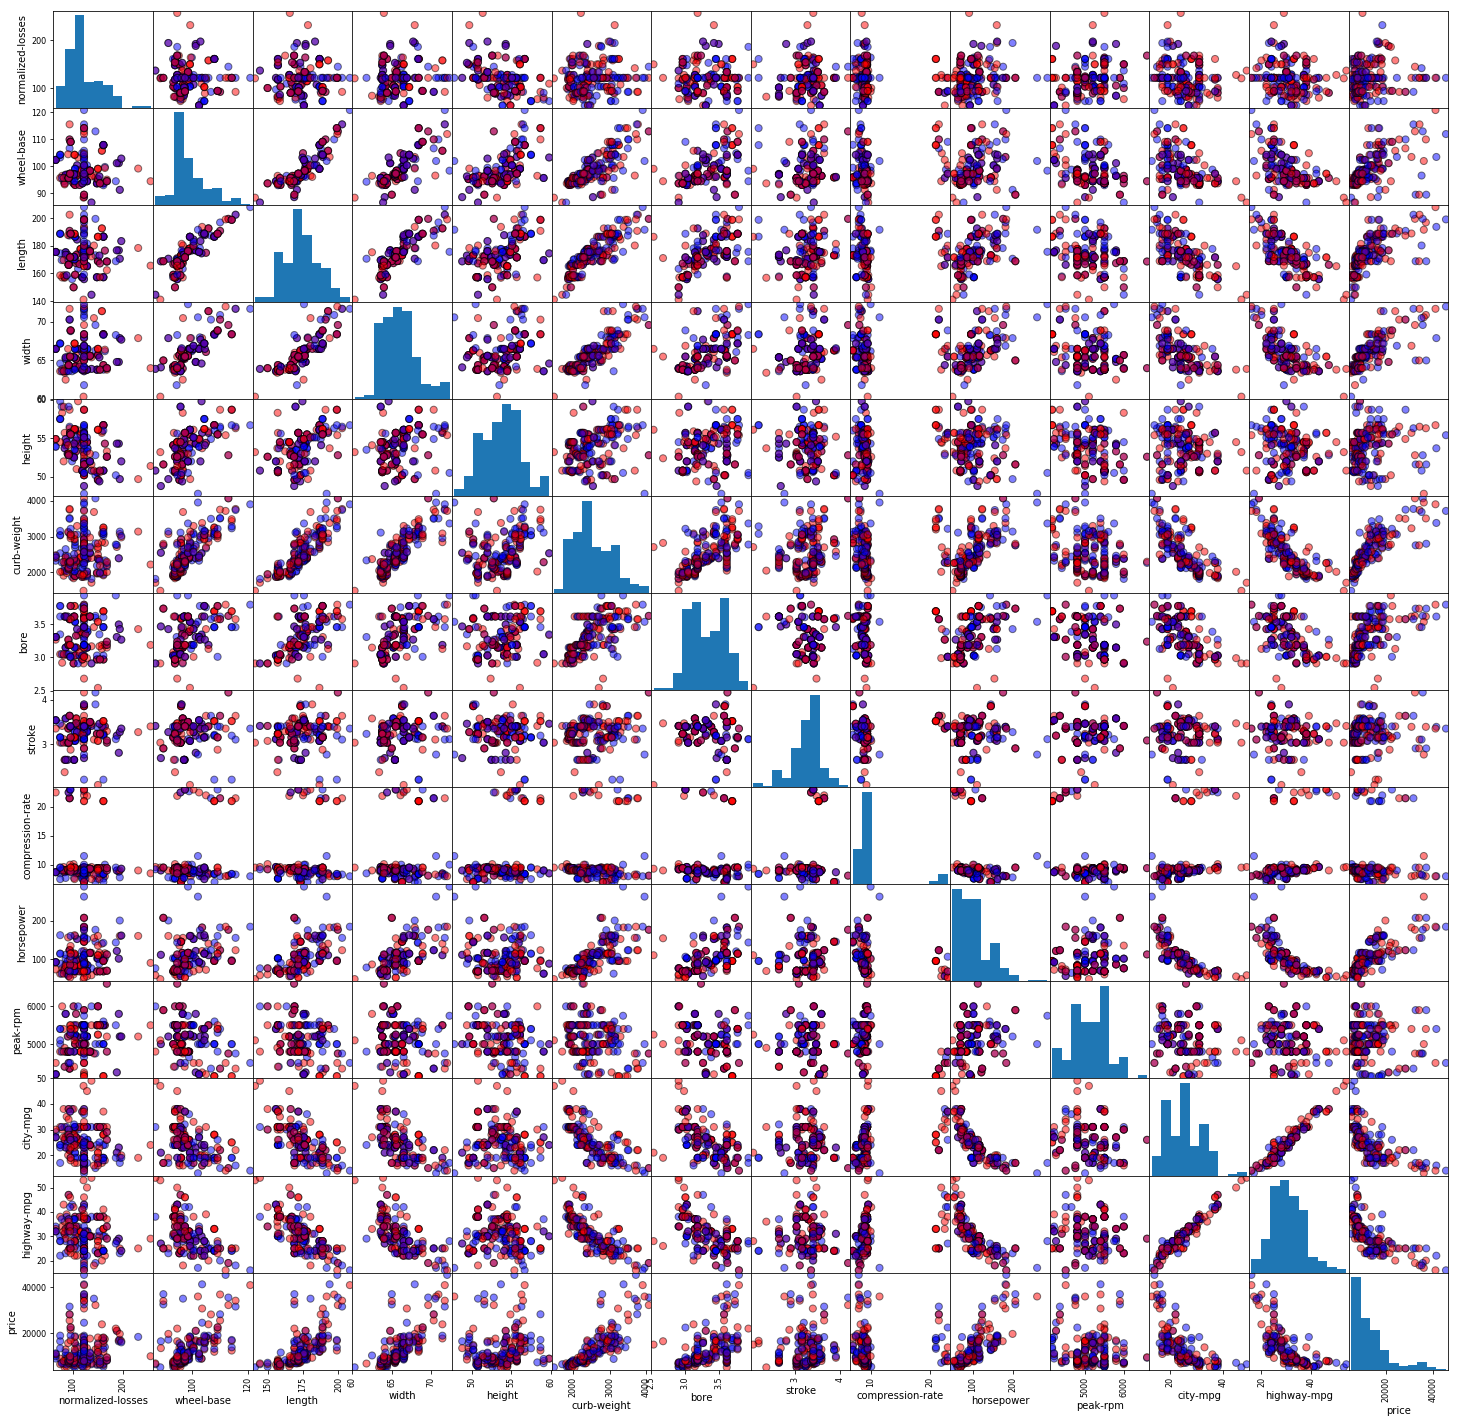

In [14]:
pd.plotting.scatter_matrix(new_cars_ref.loc[0:,new_cars_ref.columns],c=['red','blue'],alpha=0.5,figsize=[25,25],diagonal='hist',s=200,marker='.',edgecolor='black')
plt.show()

In [15]:
features = new_cars.corr()["price"].sort_values()
print(features)
features1 = features[abs(features) > 0.5]
features2 = features[abs(features) > 0.6]
features3 = features[abs(features) > 0.7]

highway-mpg         -0.690526
city-mpg            -0.667449
peak-rpm            -0.100854
compression-rate     0.070990
stroke               0.082095
normalized-losses    0.133999
height               0.134388
bore                 0.532300
wheel-base           0.583168
length               0.682986
width                0.728699
horsepower           0.757917
curb-weight          0.820825
price                1.000000
Name: price, dtype: float64


Since all of these are continuous values, we'll try to pick a cut off of 0.5 or higher in correlation with price. These would be the most effective parameter that helps us predict the value of the car.

In [16]:
features1 = features1.index.tolist()
features2 = features2.index.tolist()
features3 = features3.index.tolist()

features1.remove("price")
features2.remove("price")
features3.remove("price")

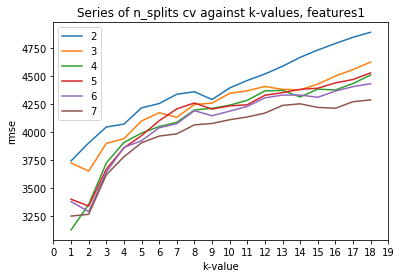

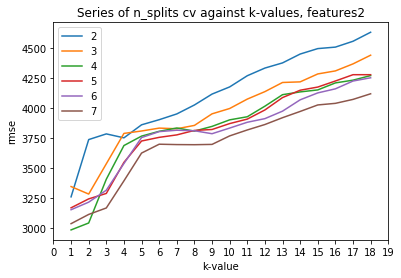

Text(0.5,1,'Series of n_splits cv against k-values, features3')

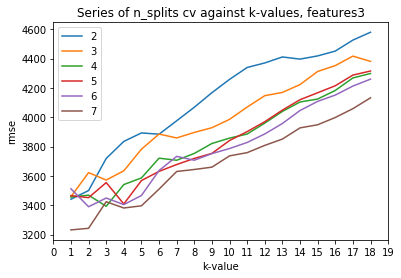

In [17]:
#let's replot our cross matrix
knn_cv1 = cv_matrix(8,20,features1,['price'],new_cars)
knn_cv2 = cv_matrix(8,20,features2,['price'],new_cars)
knn_cv3 = cv_matrix(8,20,features3,['price'],new_cars)

for key in knn_cv1:
    rmse_results = knn_cv1[key]
    #x is the size of the k values iterated above, y are the errors
    sns.lineplot(x=range(1,len(rmse_results)),y=rmse_results[1:],legend="full")
    plt.xticks([i for i in range(len(rmse_results)+1)])
plt.title("Top 8 features")
plt.legend([i for i in range(2,11)])
plt.xlabel("k-value")
plt.ylabel("rmse")
plt.title("Series of n_splits cv against k-values, features1")
plt.show()


for key in knn_cv2:
    rmse_results = knn_cv2[key]
    #x is the size of the k values iterated above, y are the errors
    sns.lineplot(x=range(1,len(rmse_results)),y=rmse_results[1:],legend="full")
    plt.xticks([i for i in range(len(rmse_results)+1)])
plt.title("Top 8 features")
plt.legend([i for i in range(2,11)])
plt.xlabel("k-value")
plt.ylabel("rmse")
plt.title("Series of n_splits cv against k-values, features2")
plt.show()

for key in knn_cv3:
    rmse_results = knn_cv3[key]
    #x is the size of the k values iterated above, y are the errors
    sns.lineplot(x=range(1,len(rmse_results)),y=rmse_results[1:],legend="full")
    plt.xticks([i for i in range(len(rmse_results)+1)])
plt.title("Top 8 features")
plt.legend([i for i in range(2,11)])
plt.xlabel("k-value")
plt.ylabel("rmse")
plt.title("Series of n_splits cv against k-values, features3")


In [18]:
features3

['width', 'horsepower', 'curb-weight']

It seems that features3 ("width","horsepower","curb-weight") seems to give us the most stable result with many different n-splits having and k-values yielding the same RMSE of ~$3400. We can try to look to other algorithms and see if they can provide by improvement

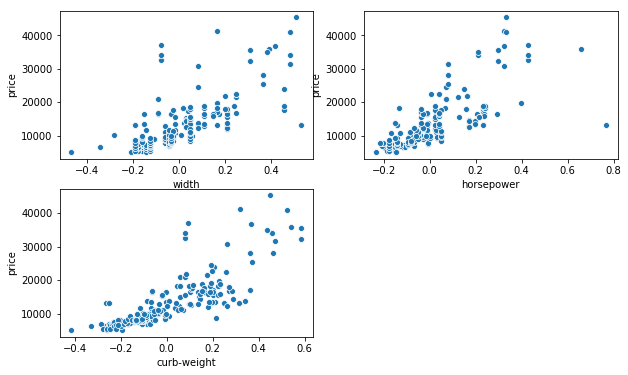

In [19]:
fig = plt.figure(figsize=(10,6))
plt.subplot(221)
sns.scatterplot(new_cars["width"],new_cars["price"])
plt.subplot(222)
sns.scatterplot(new_cars["horsepower"],new_cars["price"])
plt.subplot(223)
sns.scatterplot(new_cars["curb-weight"],new_cars["price"])
plt.show()

Note: this is with a normalized features

# Linear Regression

These are fairly linear, let's apply a linear regression algorithm to it and see what we can get out of that. It's fairly standard that proportions between parameters won't change much with Min max scaling. Therefore, the algorithm shouldnt be much dependent on raw value vs. normalized value. NONE OF OUR INTEREST PARAMETERS ARE RATIOS.

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.utils import resample
print(new_cars_ref['price'].shape)
#there are simply isn't enough data to help our machine learning algorithm to train/test. However, we'll stick with it and see what we can get.

new_df = shuffle(new_cars,random_state=10)
new_df.head()

(205,)


normalized-losses  wheel-base    length     width    height  curb-weight  \
131           0.000000   -0.077451  0.041056  0.057683 -0.268740    -0.037070   
117           0.204188    0.269487  0.188817  0.199350  0.189593     0.222822   
63            0.000000    0.001266  0.055981  0.049350  0.147927    -0.043664   
56            0.146597   -0.100775 -0.075362 -0.017317 -0.343740    -0.068102   
49            0.000000    0.094560  0.263444  0.391016 -0.493740     0.540898   

         bore        stroke  compression-rate    horsepower  peak-rpm  \
131  0.093035  3.069415e-01         -0.090159  5.921189e-17  0.000000   
117  0.200178 -2.162995e-02         -0.196409  1.572660e-01  0.193727   
63   0.043035  6.408434e-02          0.784841 -1.677340e-01 -0.194028   
56   0.000000 -2.114711e-16         -0.046409 -1.356732e-02  0.356992   
49   0.150178 -2.359157e-01          0.084841  6.572660e-01 -0.051171   

     city-mpg  highway-mpg    price  
131 -0.061653     0.006547   9895.0  
117 -0.200542    -0.177664  18150.0  
63   0.299458     0.296021  10795.0  
56  -0.228320    -0.203979  11845.0  
49  -0.339431    -0.361874  36000.0

In [21]:
#since new_df has already been shuffled
train_set = new_df[:160]
test_set = new_df[160:] #we do not want to disturb our test set


#need to correct this, essentially we're using part of the training for testing in subsequent models....
def linear_reg(train_set, test_set, features): # a list of features
    train_set = resample(train_set, replace=True, n_samples=2000) 
    #bootstrapping, no seeding for graphing the mean later.
    
    #bootstrapping, need to sample a random fraction
    train_x = train_set[:1700][features]
    train_y = train_set[:1700]['price']
    
    test_x = test_set[features]
    test_y = test_set['price']

    linear_model = LinearRegression()
    linear_model.fit(train_x,train_y)
    hypothesis = linear_model.predict(test_x)
    rmse = np.sqrt(((hypothesis - test_y)**2).mean())
    return rmse


rmse_linear1 = linear_reg(train_set,test_set,features1)
rmse_linear2 = linear_reg(train_set,test_set,features2)
rmse_linear3 = linear_reg(train_set,test_set,features3)
print(rmse_linear1)
print(rmse_linear2)
print(rmse_linear3)
print("price std: ",new_cars.price.std())

4627.565084569374
4950.984233352116
4451.755300090583
price std:  7868.7682123438


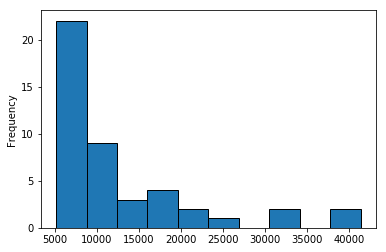

In [22]:
test_set['price'].plot.hist(bins=10,edgecolor='black')
plt.show()

It is expected for the linear regression to be better with highly correlated parameters in features set #3. However, there isn't enough training data for our model. Therefore, it isn't going to get much better than the knn algorithm
It is also understandable that with the standard deviation of 7000 dollars, a 4400 dollars rmse on our linear regression is not totally bad. It's not perfect, so let's see the distribution of our feature 3 of our prediction over many runs

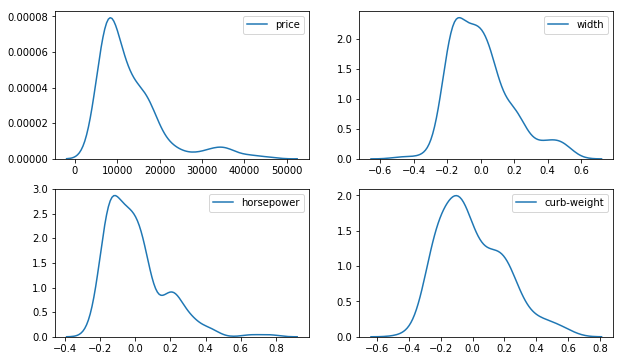

In [23]:
fig = plt.figure(figsize=(10, 6))
plt.subplot(221)
sns.kdeplot(new_cars["price"])
plt.subplot(222)
sns.kdeplot(new_cars["width"])
plt.subplot(223)
sns.kdeplot(new_cars["horsepower"])
plt.subplot(224)
sns.kdeplot(new_cars["curb-weight"])
plt.show()
fig.tight_layout()

In [24]:
rmse_linear_lst = []
#1000 times
for i in range (0,1000):
    rmse_linear_lst.append(linear_reg(train_set,test_set,features3))
print(np.mean(rmse_linear_lst), np.std(rmse_linear_lst))
rmse_linear_lst

4619.647115122523 139.3951889266766


[4354.650744757818,
 4493.872273389443,
 4732.309841559018,
 4676.089998591929,
 4370.579812290216,
 4661.9717019632435,
 4752.695457783552,
 4469.400293749316,
 4268.279184543753,
 4800.018269644821,
 4846.73393018115,
 4518.345748111982,
 4746.10678703441,
 4700.92919968369,
 4695.07464732849,
 4542.317652349441,
 4584.913254884668,
 4653.262507790333,
 4693.240947410114,
 4661.642305268522,
 4473.389216441986,
 4786.505987865477,
 4858.659749744179,
 4700.534472332105,
 4426.594908055426,
 4557.820720781773,
 4721.411806601528,
 4770.278636794447,
 4708.829275963408,
 4535.944348713585,
 4518.757694765719,
 4656.443294905306,
 4411.6994132185455,
 4518.782392835982,
 4735.609702132634,
 4728.90166273601,
 4748.414245050986,
 4622.555059364704,
 4590.920096095361,
 4758.065461906205,
 4841.2458774277175,
 4511.109202525032,
 4754.655448712856,
 4481.697428752221,
 4559.666113769804,
 4618.861164516487,
 4466.314528560025,
 4530.889047704116,
 4713.515304302661,
 4794.210499435526,
 4

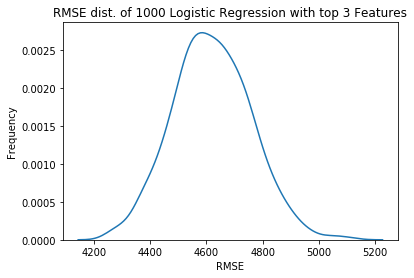

(4610.992662184904, 4628.301568060143)
4619.647115122523 4613.938561670744 139.46493883793494


In [25]:
#now we look at the distribution of our frequency plot and finalement, we calculate the quantile to see our confidence level.
import scipy.stats as stats

rmse_linear_lst = pd.Series(rmse_linear_lst)
sns.kdeplot(rmse_linear_lst)
plt.title("RMSE dist. of 1000 Logistic Regression with top 3 Features")
plt.xlabel("RMSE")
plt.ylabel("Frequency")
plt.show()

#95% confidence interval, with mean and standard errors
def conf_interval_mean(dist, ci=0.95):
    # ppf: Percent Point Function (Inverse of CDF)
    mean, stderr, m = np.mean(dist), stats.sem(dist), stats.t.ppf((1+ci)/2, len(dist)-1)
    lower, upper = (mean-stderr*m, mean+stderr*m)
    return lower,upper
print(conf_interval_mean(rmse_linear_lst,0.95))
print(rmse_linear_lst.mean(),rmse_linear_lst.median(),rmse_linear_lst.std())


Fairly a consistent result. This is attributed to the bootstrapping method for limited data.

In [26]:
#recall that feature set #2 gave us comparable results to feature set #3. Let's see if this is still hold true for the mean distribution of our RMSE
rmse_linear_lst2 = []
#1000 times
for i in range (0,1000):
    rmse_linear_lst2.append(linear_reg(train_set,test_set,features2))
print(np.mean(rmse_linear_lst2), np.std(rmse_linear_lst2))
#rmse_linear_lst

4658.598869971595 153.64369043286


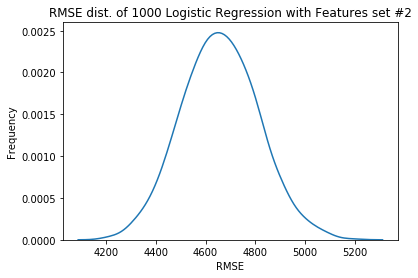

(4649.0597883271585, 4668.137951616032)
4658.598869971595 4656.570351971606 153.72056994251608


In [27]:
#now we look at the distribution of our frequency plot and finalement, we calculate the quantile to see our confidence level.
import scipy.stats as stats

rmse_linear_lst2 = pd.Series(rmse_linear_lst2)
sns.kdeplot(rmse_linear_lst2)
plt.title("RMSE dist. of 1000 Logistic Regression with Features set #2")
plt.xlabel("RMSE")
plt.ylabel("Frequency")
plt.show()

#95% confidence interval, with mean and standard errors
def conf_interval_mean(dist, ci=0.95):
    # ppf: Percent Point Function (Inverse of CDF)
    mean, stderr, m = np.mean(dist), stats.sem(dist), stats.t.ppf((1+ci)/2, len(dist)-1)
    lower, upper = (mean-stderr*m, mean+stderr*m)
    return lower,upper
print(conf_interval_mean(rmse_linear_lst2,0.95))
print(rmse_linear_lst2.mean(),rmse_linear_lst2.median(),rmse_linear_lst2.std())

It's arguable if this is worse than the previous top 3 features set. However, we can safely say that the 1 time evaluation of Linear Regression did not prove that feature set #3 was a lot better than feature set #2. Also, bootstrapping has provided us with a nice mean distribution for a limited data set (one can look at earlier version of the notebook and see how skewed they can be!).

Indeed, none of the listed are any better than the KNN regression model.


# Machine Learning Model #3: SVR

Due to convergence issue, we'll be using normalized data to predict the price instead of the raw values.

In [28]:
from sklearn.svm import SVR
#tuning with kernel and error penalty factor (we want large C to penalize a poorly chosen hyperplane)
svr_rbf = SVR(kernel='rbf', C=1e9, gamma='auto')
svr_lin = SVR(kernel='linear', C=1e9)
svr_poly = SVR(kernel='poly', C=1e9, degree=2) #we know that it's mostly linear with feature set #3
y_rbf3 = svr_rbf.fit(train_set[features3], train_set["price"]).predict(test_set[features3])
y_lin3 = svr_lin.fit(train_set[features3], train_set["price"]).predict(test_set[features3])
y_poly3 = svr_poly.fit(train_set[features3], train_set["price"]).predict(test_set[features3])

rmse_rbf3 = np.sqrt(mean_squared_error(test_set["price"],y_rbf3))
rmse_lin3 = np.sqrt(mean_squared_error(test_set["price"],y_lin3))
rmse_poly3 = np.sqrt(mean_squared_error(test_set["price"],y_poly3))
print(rmse_rbf3, rmse_lin3, rmse_poly3)

4540.098616949744 5418.097004191327 6892.172497803617


In [29]:
svr_rbf = SVR(kernel='rbf', C=1e9, gamma='auto')
svr_lin = SVR(kernel='linear', C=1e9)
svr_poly = SVR(kernel='poly', C=1e9, degree=3)
y_rbf2 = svr_rbf.fit(train_set[features2], train_set["price"]).predict(test_set[features2])
y_lin2 = svr_lin.fit(train_set[features2], train_set["price"]).predict(test_set[features2])
y_poly2 = svr_poly.fit(train_set[features2], train_set["price"]).predict(test_set[features2])

rmse_rbf2 = np.sqrt(mean_squared_error(test_set["price"],y_rbf2))
rmse_lin2 = np.sqrt(mean_squared_error(test_set["price"],y_lin2))
rmse_poly2 = np.sqrt(mean_squared_error(test_set["price"],y_poly2))
print(rmse_rbf2, rmse_lin2, rmse_poly2)

4203.507363938328 5462.2902672753025 6527.899752203079


In [30]:
svr_rbf = SVR(kernel='rbf', C=1e9, gamma='auto')
svr_lin = SVR(kernel='linear', C=1e9)
svr_poly = SVR(kernel='poly', C=1e9, degree=3)
y_rbf1 = svr_rbf.fit(train_set[features1], train_set["price"]).predict(test_set[features1])
y_lin1 = svr_lin.fit(train_set[features1], train_set["price"]).predict(test_set[features1])
y_poly1 = svr_poly.fit(train_set[features1], train_set["price"]).predict(test_set[features1])

rmse_rbf1 = np.sqrt(mean_squared_error(test_set["price"],y_rbf1))
rmse_lin1 = np.sqrt(mean_squared_error(test_set["price"],y_lin1))
rmse_poly1 = np.sqrt(mean_squared_error(test_set["price"],y_poly1))
print(rmse_rbf1, rmse_lin1, rmse_poly1)

4386.486612879874 5475.02015938897 5480.597257215027


Generally, a higher C parameter helps reduce the errors for our rbf (Radial basis function) kernel. The error begins to plateau around rmse = 4500 at C=1e7.
It is understandable for a regression model to be critical with the error penalty to choose the best hyperplane to fit our line. Finally, let's choose the rbf kernel with feature set #3 to benchmark against other algorithm with bootstrapping

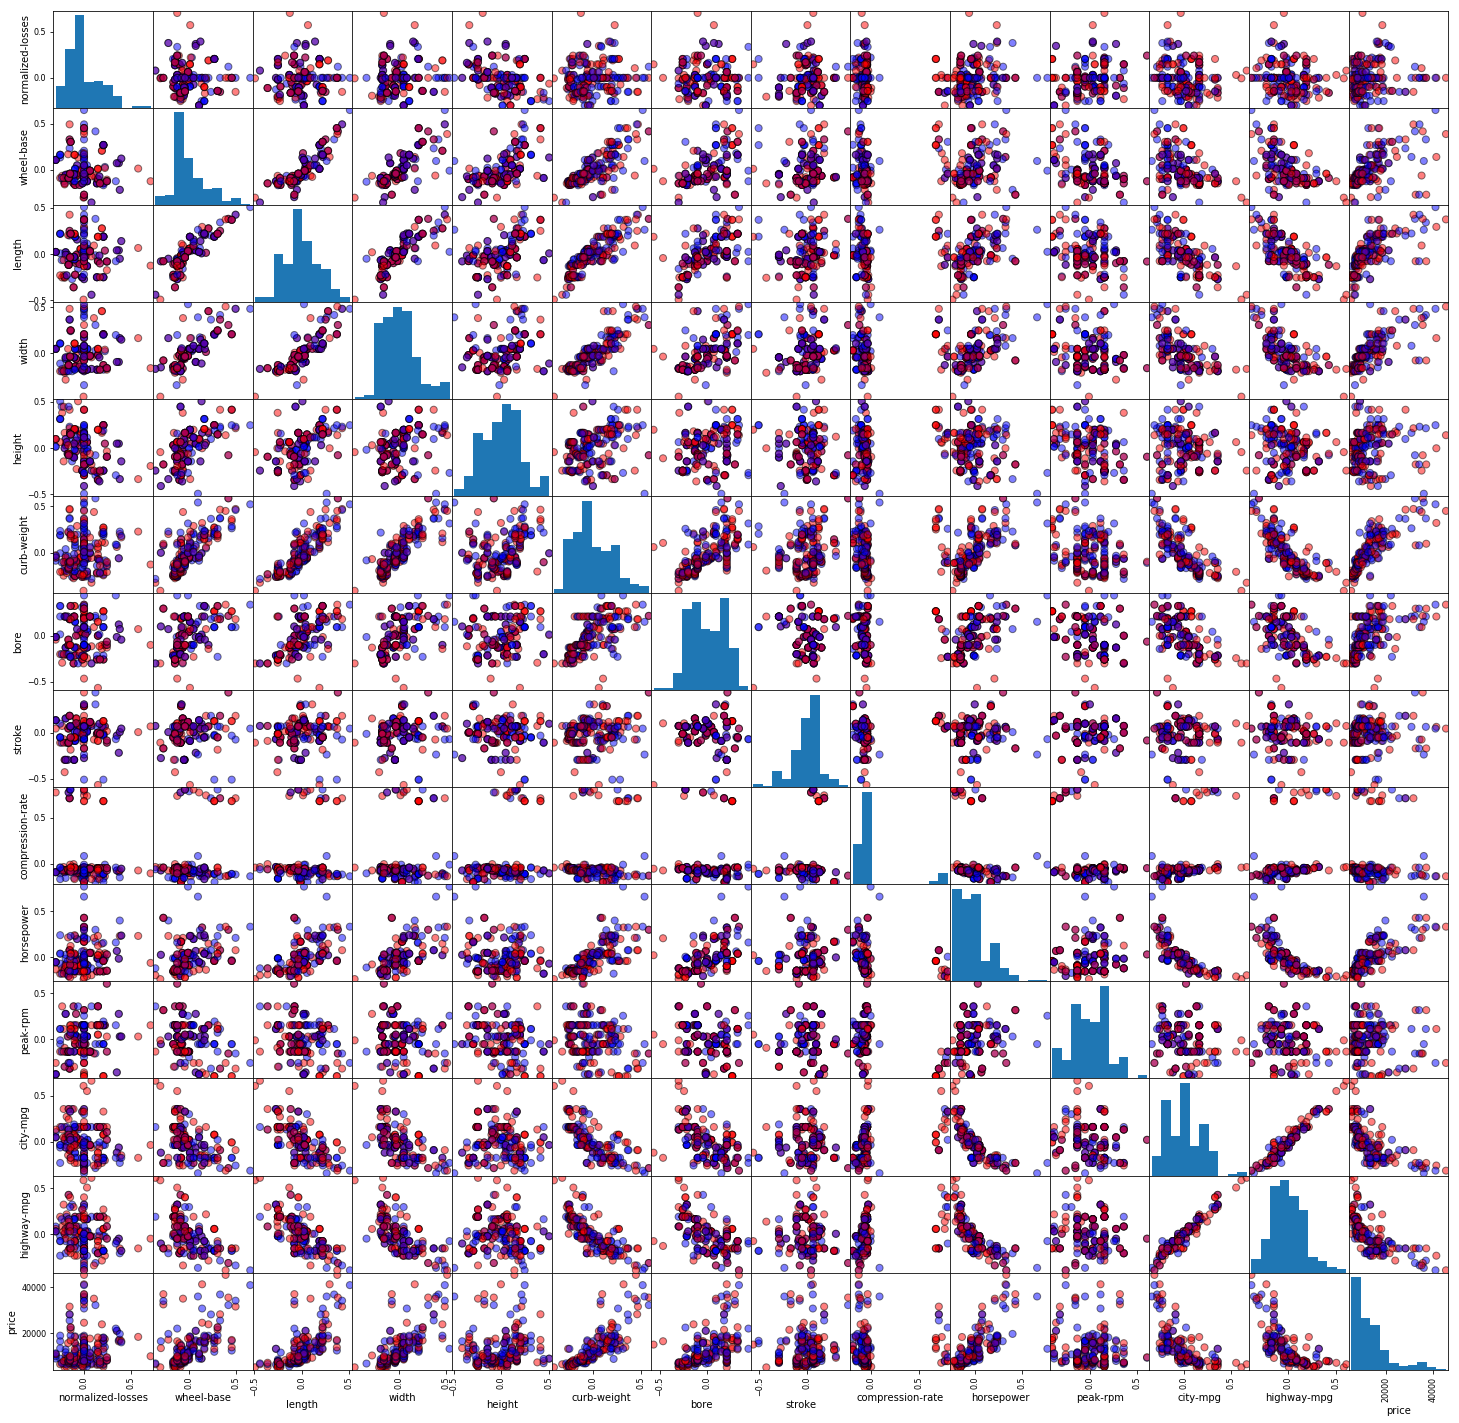

features set #3:  ['width', 'horsepower', 'curb-weight']


In [31]:
pd.plotting.scatter_matrix(new_cars.loc[0:,new_cars.columns],c=['red','blue'],alpha=0.5,figsize=[25,25],diagonal='hist',s=200,marker='.',edgecolor='black')
plt.show()
print("features set #3: ", features3)

In [32]:
#need to correct this, essentially we're using part of the training for testing in subsequent models....
def svr_rbf_model(train_set, test_set, features, error_pen): # a list of features
    rmse_rbf3_list = []
    for i in range(7): #computationally intensive, we'll just use 7
        train_set = resample(train_set, replace=True, n_samples=2000) 
        #bootstrapping, no seeding for randomness

        #bootstrapping, need to sample a random fraction
        train_x = train_set[:1700][features]
        train_y = train_set[:1700]['price']

        test_x = test_set[features]
        test_y = test_set['price']

        svr_rbf3 = SVR(kernel='rbf', C=error_pen, gamma='auto')
        y_rbf3 = svr_rbf3.fit(train_set[features1], train_set["price"]).predict(test_set[features1])
        rmse_rbf3 = np.sqrt(mean_squared_error(test_set["price"],y_rbf3))
        rmse_rbf3_list.append(rmse_rbf3)
    return np.mean(rmse_rbf3_list)

svr_rbf3_lst = []
C_list = [10**i for i in range(9)]

for i in C_list:
    svr_rbf3_lst.append(svr_rbf_model(train_set,test_set,features3, i))

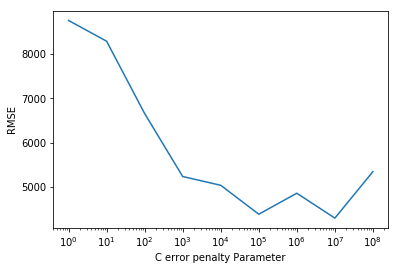

In [33]:
plt.semilogx(C_list,svr_rbf3_lst)
plt.xlabel("C error penalty Parameter")
plt.ylabel("RMSE")
plt.show()

In [34]:
print(C_list)
print(svr_rbf3_lst)

[1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]
[8759.371041929433, 8290.70207505258, 6658.229482984886, 5235.926040673612, 5037.4161317386315, 4384.460713395334, 4858.423165383125, 4296.417734251915, 5346.5558731654555]


Conclusion:

We got around ~4500 dollars for Linear Regression and SVR algorithm. However, KNN regressor Kfold shows the best result, about ~3500 dollars. It is important to look at the features we're interested in; choose algorithms appropriate for those features, and evaluate our metric/overfitting/underfitting issues. 